In [19]:
# Dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.sql import func
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date, timedelta
import datetime as dt
import pandas as pd
from pandas import DataFrame

In [20]:
# Create engine & connection
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)
conn = engine.connect()

In [21]:
# Create automap
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [23]:
# Start a session to query the database
session = Session(engine)

In [24]:
# Use `engine.execute` to select and display the first 10 rows from the table

engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', 0.0, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [25]:
# Reflect Database into ORM class# Refle 
Station = Base.classes.station
Measurements = Base.classes.measurement

# Precipitation Analysis

In [26]:
# Grabs the last date entry in the data table
last_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
print(last_date)

('2017-08-23',)


In [27]:
# to get the last 12 months of data, last date - 365
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [28]:
# query to pull the last year of precipitation data
rain = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

In [39]:
# Load the data from the query into a dataframe

rain_df = pd.DataFrame(rain)
rain_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,0.00
4,2016-08-24,1.22


In [36]:
# reset the index to the date

# rain_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,0.00
2016-08-24,1.22


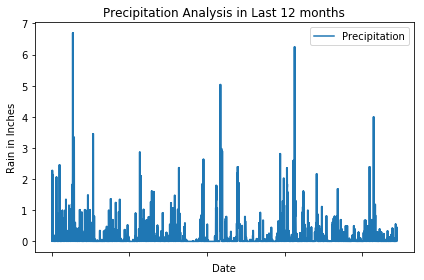

In [40]:
# plot the dataframe
rain_df.plot('date', 'prcp')
# ax.bar(rain_df.index.get_values(),color='b',align='center', label="Precipitation")
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis in Last 12 months")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('images/Hawaii Precipitation in the Last 12 months.png')
plt.show()

In [32]:
# Use Pandas to print the summary statistics for the precipitation data.
rain_df.describe()

,prcp
count,4446.000000
mean,0.159951
std,0.441170
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Station Analysis

In [41]:

# Count the number of stations in the Measurement table# Count  
locations = session.query(Measurements).group_by(Measurements.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [42]:
# find the station with the most temperature observations, then list them all in descending order
busy_station = session.query(Measurements.station, func.count(Measurements.tobs)).group_by(Measurements.station).\
               order_by(func.count(Measurements.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest Station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")
for station, count in busy_station:
    print("Station",station,"had",count, "weather observations.")

The busiest Station was USC00519281 with 5544 weather observations.

Here are all of the Stations (in descending order) with their number of observations:
Station USC00519281 had 5544 weather observations.
Station USC00519397 had 5448 weather observations.
Station USC00513117 had 5418 weather observations.
Station USC00519523 had 5338 weather observations.
Station USC00516128 had 5224 weather observations.
Station USC00514830 had 4404 weather observations.
Station USC00511918 had 3958 weather observations.
Station USC00517948 had 2744 weather observations.
Station USC00518838 had 1022 weather observations.


In [44]:
# query to pull the last year of precipitation data for the busiest station
temperature = session.query(Measurements.station, Measurements.date, Measurements.tobs).\
    filter(Measurements.station == busiest).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

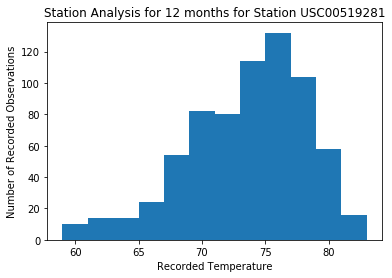

In [48]:
# plot the temperature data in a histogram with 12 bins
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis for 12 months for Station " + busiest)

plt.savefig('images/Histogram of Temperature.png')
plt.show()

# Temparature Analysis

In [49]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()
temp_range = (calc_temps('2012-02-28', '2012-03-05'))
print(temp_range)

[(62.0, 69.57142857142857, 74.0)]


In [50]:
# calculate the min/max/avg from last year that matches my trip date
trip_arrive = dt.date(2018, 4, 1)
trip_leave = dt.date(2018, 4, 15)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(67.0, 74.47368421052632, 82.0)]


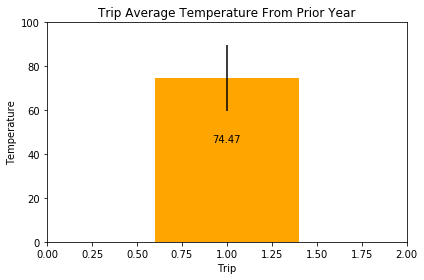

In [52]:
# plot the calculated min/max/avg from last year for the trip dates as a bar chart

p2p = temp_avg_lst_year[0][2]-temp_avg_lst_year[0][0]
avgtemp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'orange', yerr=p2p)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature")
ax.set_title("Trip Average Temperature From Prior Year")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=10)

        
    # label the bars 
autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
plt.tight_layout()

plt.savefig("images/Temperature_analysis.png")
plt.show()

# Optional Recommended Analysis


In [56]:

Rainfall_results  = session.query(Measurements.station, func.count(Measurements.prcp)).\
                   group_by(Measurements.station).filter(Measurements.date.between('2016-08-01', '2017-08-01')).all()
Rainfall_results

[('USC00513117', 730),
 ('USC00514830', 608),
 ('USC00516128', 700),
 ('USC00517948', 394),
 ('USC00519281', 730),
 ('USC00519397', 726),
 ('USC00519523', 682)]

In [57]:
for i in range(1,16):
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [59]:

from  sqlalchemy  import extract  
trip_month=8
trip_days=range(1, 16)
for i in range(1, 16):
    subquery=session.query(Measurements.date).filter(extract('month', Measurements.date)==trip_month).\
             filter(extract('day', Measurements.date)== i ).group_by(Measurements.date).order_by(Measurements.date).all()
subquery

[('2010-08-15'),
 ('2011-08-15'),
 ('2012-08-15'),
 ('2013-08-15'),
 ('2014-08-15'),
 ('2015-08-15'),
 ('2016-08-15'),
 ('2017-08-15')]

In [60]:
dates=[]
daily_normals_Three_AVG=[]
daily_normals_TMAX=[]
daily_normals_TMIN=[]
daily_normals_TAVG=[]

trip_month=8
trip_days=range(1, 16)

def daily_normals():
    
    for i in range(1,16):
        results=session.query(Measurements.date.label("dates"), func.max(Measurements.tobs).label("max_tobs"),\
                             func.min(Measurements.tobs).label("min_tobs"),func.avg(Measurements.tobs).label("avg_tobs")).\
                             filter(extract('month', Measurements.date)==trip_month).\
                             filter(extract('day', Measurements.date)== i ).group_by(Measurements.date).order_by(Measurements.date)
        results
        for res in results.all():
             print( res)
        
        res
        TMAX = res.max_tobs
        TMIN= res.min_tobs
        TAVG= res.avg_tobs
        Date= res.dates
        
        data = [TMAX, TMIN, TAVG]
        #avg = [float(sum(col))/len(col) for col in zip(*data)]

        dates.append(Date)
        #daily_normals_Three_AVG.append(avg)
        daily_normals_TMAX.append(TMAX)
        daily_normals_TMIN.append(TMIN)
        daily_normals_TAVG.append(TAVG)
        
daily_normals()


('2010-08-01', 77.0, 71.0, 73.42857142857143)
('2011-08-01', 78.0, 67.0, 73.375)
('2012-08-01', 79.0, 71.0, 75.85714285714286)
('2013-08-01', 79.0, 75.0, 76.83333333333333)
('2014-08-01', 83.0, 73.0, 77.42857142857143)
('2015-08-01', 79.0, 73.0, 77.4)
('2016-08-01', 78.0, 73.0, 76.16666666666667)
('2017-08-01', 77.0, 72.0, 74.5)
('2010-08-02', 76.0, 70.0, 73.22222222222223)
('2011-08-02', 77.0, 70.0, 73.625)
('2012-08-02', 78.0, 68.0, 73.5)
('2013-08-02', 78.0, 70.0, 74.57142857142857)
('2014-08-02', 81.0, 73.0, 77.71428571428571)
('2015-08-02', 84.0, 76.0, 80.0)
('2016-08-02', 80.0, 72.0, 76.57142857142857)
('2017-08-02', 83.0, 73.0, 79.0)
('2010-08-03', 77.0, 70.0, 73.11111111111111)
('2011-08-03', 78.0, 71.0, 75.25)
('2012-08-03', 78.0, 72.0, 74.57142857142857)
('2013-08-03', 79.0, 72.0, 76.66666666666667)
('2014-08-03', 83.0, 74.0, 78.33333333333333)
('2015-08-03', 85.0, 75.0, 80.0)
('2016-08-03', 82.0, 74.0, 78.42857142857143)
('2017-08-03', 81.0, 76.0, 79.0)
('2010-08-04', 77.0, 

In [61]:
Daily_normals_df= pd.DataFrame({'Date': dates, 'TMAX': daily_normals_TMAX, 'TMIN': daily_normals_TMIN,'TAVG': daily_normals_TAVG,})
Daily_normals_df.set_index('Date', inplace=True, )
Daily_normals_df.head()

,TAVG,TMAX,TMIN
Date,,,
2017-08-01,74.5,77.0,72.0
2017-08-02,79.0,83.0,73.0
2017-08-03,79.0,81.0,76.0
2017-08-04,80.0,82.0,77.0
2017-08-05,80.0,82.0,77.0


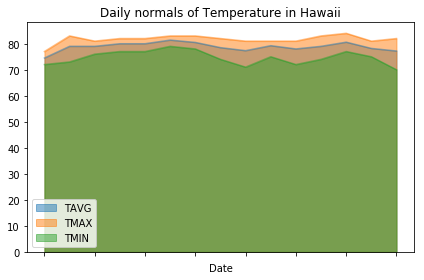

In [64]:
fig = plt.figure(figsize=(9, 11))
ax = Daily_normals_df.plot(kind='area', stacked=False, title='Daily normals of Temperature in Hawaii')
ax.set_xlabel('Date')
plt.tight_layout()
plt.savefig('images/Daily normals of Temperature in Hawaii.png', bbox_inches = 'tight')
plt.show()